# Finite Element Tutorial in Python
Introduction to python module for Finite Element Analysis with elements in 1-d or 2-d. Allows laminate geometries and materials with anisotropic linear elasticity.

Author: Alexander Hartmaier, ICAMS / Ruhr-Universität Bochum

June 2019

## Python Laboratory for Finite Element Analysis (pyLabFEA)
Defines a class `Model` for the finite element model. Call class to generate a container for the Finite Element Model. This container stores all attributes of the model and defines the methods. On this model, the following steps are performed: (i) geometry definition, (ii) material definition, (iii) applying boundary conditions, (iv) meshing, (v) solving of linear equations, and (vi) calculation of element stresses and strains by calling the corresponding methods of the class `Model`. Also provides a class `Materials` for material definitions.

Uses NumPy (http://www.numpy.org) and matplotlib (https://matplotlib.org/).

In [2]:
import sys
if ("../source" not in sys.path):
    sys.path.append("../source")

import pyLabFEM as FE
from pyLabMaterial import Material

## Model

Generate a container for the Finite Element Model. This container stores all model attributes and defines the methods to be applied. On this model, the following steps are performed: (i) geometry definition, (ii) material definition, (iii) applying boundary conditions, (iv) meshing, (v) solving of linear equations for mechanical equilibrium, and (vi) calculation of global stresses and strains by calling the corresponding methods of the class `Model`. 

<b>Parameters:</b> <br/>
dim (optional): dim=1 for 1-d model, dim=2 for 2-d model (default: dim=1)<br/>
planestress (optional, used only in 2-d models): True if plane stress conditions shall be considered (default: planestress=False)<br/>

<b> Methods: </b><br/>
`geom`: define (laminate) geometry with sections<br/>
`assign`: assign material properties to sections<br/>
`bcleft`, `bcright`, `bctop`, `bcbot`: define boundary conditions<br/>
`mesh`: generate mesh (1-d elements with linear or quadratic shape functions or 2-d mesh with linear quadriliteratl elements)<br/>
`solve`: setup stiffness matrix and calculate displacements satisfying mechanical equilibrium, i.e. $f=0$ for internal nodes, for given boundary conditions <br/>
`calc_global`: calculate global stress and strain based on displacements and residual forces of boundary nodes <br/>
`plot`: show graphical representation of mechanical quantities mapped into deformed shape


In [3]:
fem = FE.Model()   # create element of class Model

## Geometry

Define the geometry of the model with method `geom`. The geometry is subdivided into sections, representing a 1-d or 2-d laminate structure normal to the $x$-direction. The sections are given as a list with the absolute length of each section. The total length of the model is the sum of all section lengths.

<b>Parameters:</b><br/>
sect: list with absolute length of each section in x-direction<br/>
LY (optional): height of model in y-direction (default: LY=1)<br/>
LZ (optional): thickness of model in z-direction (default: LZ=1)<br/>

In [4]:
fem.geom([3, 2, 4])  # define sections in absolute lengths

## Materials

Material properties are given either in terms of anisotropic elastic constants $C_{11}$, $C_{12}$, $C_{44}$, or – in case of an elastically isotropic material – as Young's modulus $E$ and Poisson's ratio $\nu$. The parameters must be given with their name. The material is created by applying the class `Material`, which defines a container for the attributes and methods describing material properties and behavior. Elastic properties are defined by calling the method `elasticity` with the appropriate set of parameters.  

<b>Class:</b><br/>
`Material`

<b>Methods:</b><br/>
`elasticity:` define linear elastic material either by anisoptropic or by isotropic constants. Note: One complete set of elastic parameters must be provided.<br/>
<b>Paramaters:</b><br/>
C11, C12, C44 (optional): anisotropic elastic constants<br/>
E, nu (optional): Young's modulus and Poisson's ratio (isotropic elasticity)<br/>
one of both parameter sets must be provided<br/>

<b>Attributes:</b><br/>
sets internal variables for $C_{11}$, $C_{12}$, $C_{44}$, $E$ and $\nu$ <br/>



In [5]:
mat1 = Material()                    # create element of class Material
mat1.elasticity(E=200.e3, nu=0.3)    # assign isotropic elastic properties
mat2 = Material()
mat2.elasticity(E=100.e3, nu=0.3)
mat3 = Material()
mat3.elasticity(E=500.e3, nu=0.3)
print('MAT1: C11, C12, C44, E, nu', mat1.C11, mat1.C12, mat1.C44, mat1.E, mat1.nu)
print('MAT2: C11, C12, C44, E, nu', mat2.C11, mat2.C12, mat2.C44, mat2.E, mat2.nu)
print('MAT3: C11, C12, C44, E, nu', mat3.C11, mat3.C12, mat3.C44, mat3.E, mat3.nu)


MAT1: C11, C12, C44, E, nu 269230.76923076925 115384.61538461539 76923.07692307692 200000.0 0.3
MAT2: C11, C12, C44, E, nu 134615.38461538462 57692.307692307695 38461.53846153846 100000.0 0.3
MAT3: C11, C12, C44, E, nu 673076.923076923 288461.53846153844 192307.6923076923 500000.0 0.3


## Assigning materials to model sections

Each section has to be assigned a material, which is accomplished by calling the according method of the class `Model` with the list of materials, which must have the same shape as the list of sections in the geometry definition.

<b>Class: </b>`Model`<br/>
<b>Method:</b><br/>
`assign`: assign a material to each section<br/assign: assign a material to each section<br/>
<b>Paramaters:</b><br/>
mats: list of materials, each defined by class `Material`, with same shape as in method `geom`. Each section is assigned to the according material.<br/>
<b>Attributes</b><br/>
fem.mat: list with pointer to material for each section<br/>

In [6]:
fem.assign([mat1, mat2, mat3])  # assign materials to sections of model
print(fem.mat)


[<pyLabMaterial.Material object at 0x1a1b5e8750>, <pyLabMaterial.Material object at 0x1a1b5e8790>, <pyLabMaterial.Material object at 0x1a1b5e8890>]


## Boundary Conditions

For left-hand-side and bottom nodes a displacement is given, typically $u_{\rm left}=u_{\rm bot}=0$.

The type of boundary conditions for right-hand-side and top nodes is specified as either displacement (type='disp') or force (type='force'). Value and type must be specified as parameters in this sequence.

For 1-d models only `bcleft` and `bcright` can be called.

<b>Method:</b><br/>
`bcleft`: set displacement for lhs node(s)<br/>
`bcbot`: set displacement for bottom node(s), has no function for 1-d models<br/>
<b>Paramaters:</b><br/>
scalar value: Displacement for boundary node(s)

<b>Method:</b><br/>
`bcright`: set displacement or force for rhs node(s)<br/>
`bctop`: set displaement or force for top node(s), has no function for 1-d models<br/>
<b>Paramaters:</b><br/>
scalar value: Displacement of force for boundary nodes<br/>
bctype: string indicating type of boundary conditions: 'disp' for displacements, 'force' for forces

In [7]:
fem.bcleft(0.)     # define displacement boundary condition on lhs node (u_x given as parameter)
fem.bcright(0.1*fem.lenx, 'disp')   # rhs node is subject to 10% strain (disp = 0.1 * length of model)


## Meshing

Create a mesh with 1-d elements or 2-d quadrilateral elements. Nodes are situated at the corners of the elements and in the middle of the edges for quadratic shape functions. The finite elements of the model are stored in a list with elements of the subclass `element` with its own attributes and methods, which are used to setup the element shape function.

<b>Method (class Model):</b><br/>
mesh<br/>
<b>Parameters:</b> <br/>
NX (optional): number of elements in x-direction (default: NX=10)<br/>
NY (optional): number of elements in y-direction (default: NY=1), only effective for 2-d models<br/>
SF (optional): degree of shape functions: 1=linear (default), 2=quadratic

<b>Subclass: `Element` (parent class: `Model`)</b><br/>
<b>Methods:</b><br/>
calc_Bmat: Calculate B matrix at Gauss point<br/>
calc_quant: calculate element stress and  strain<br/>
<b>Attributes:</b><br/>
nodes: list of nodes of this element<br/>
Lelx, Lely: x- and y-dimensions of element<br/>
ngp: number of Gauss points<br/>
gpx, gpy: np.arrays of x- and y-locations of Gauss points in element<br/>
Bmat: list of B-matrices at Gauss points<br/>
Vel: volume of element<br/>
Kel: element stiffness matrix<br/>
Jac: determinant of Jacobian<br/>
wght: weight factor for each Gauss point in integration<br/>
Sect: Section of model in which element is located<br/>
Mat: Pointer to class Material to be applied to this element<br/>
CV: Voigt stiffness matrix of element material<br/>
eps: average element (total) strain in Voigt notation<br/>
sig: average element stress in Voigt notation<br/>


In [8]:
fem.mesh(NX=9)   # create mesh
print('nodal positions: ', fem.npos.round(decimals=2))
print('nodes belonging to element #0: ', fem.element[0].nodes)
print('stiffness matrix of element #0:')
print(fem.element[0].Kel.round(decimals=2))


nodal positions:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
nodes belonging to element #0:  [0, 1]
stiffness matrix of element #0:
[[ 269230.77 -269230.77]
 [-269230.77  269230.77]]


## Solver

The system of linear equation defined by the stiffness matrix is solved, resulting in nodal displacements fulfilling mechanical equilibrium for the given boundary conditions. The nodal forces of internal nodes are zero, forces on boundary nodes are either given as boundary conditions or are residual forces on fixed boundary nodes. If no boundary conditions are specified, the force on such boundary nodes will be zero.

After solution is completed, the following attributes of the <b>class `Model`</b> are defined.<br/>
<b>Attributes:</b><br/>
u: list of nodal displacements<br/>
f: list of nodal forces<br/>
element[i].eps, element[i].sig: Voigt strain and strain tensor of element #i<br/>

In [9]:
fem.solve()     # solve linear system of equations
print('nodal displacements u = ',fem.u.round(decimals=2))
print('nodal forces f = ',fem.f.round(decimals=2))
print('element strain eps_1 = ',[element.eps[0].round(decimals=2) for element in fem.element])
print('Voigt strain tensor for element #0 = ', fem.element[0].eps.round(decimals=2))


nodal displacements u =  [0.   0.1  0.21 0.31 0.52 0.73 0.77 0.82 0.86 0.9 ]
nodal forces f =  [-28175.31      0.        0.        0.        0.       -0.       -0.
      0.       -0.    28175.31]
element strain eps_1 =  [0.1, 0.1, 0.1, 0.21, 0.21, 0.04, 0.04, 0.04, 0.04]
Voigt strain tensor for element #0 =  [0.1 0.  0.  0.  0.  0. ]


## Postprocessing

Calculate global stresses and strains based on displacements and residual forces on boundary nodes. Provide a graphical output of the specified field, the parameter can be either 'strain' or 'stress'. A rectangle is plotted for each element, with the color given by the specified field and a color map.

<b>Class `Model`</b><br/>
<b>Method:</b><br/>
`calc_global`: Calculate global stresses and strains based on displacements and residual forces of boundary nodes.<br/>
<b>Attributes:</b><br/>
glob: Python dictionary with global strains and stresses, contains the elements: <br/>
        'ebc1', 'ebc2', 'sbc1', 'sbc2' : global strain and stress calculated from boundary conditions
        (type: float) <br/>
        'eps', 'epl', 'sig',  : global strain, plastic strain, and stress tensors homogenized 
        from element solutions (type: Voigt tensor) 

<b>Method:</b><br/>
`plot`: Calculate stresses and strains for each element and stores them in lists assigned to model.<br/>
<b>Parameters:</b><br/>
fsel: field selector, string with value 'strain1' for $\epsilon_1$, 'strain2' for $\epsilon_2$, 'stress1' for $\sigma_1$, 'stress2' for $\sigma_2$.<br/>
mag (optional): scaling factor (magnification) for displacements (default: mag=10)<br/>
cdepth (optional): depth of colormap (default: cdepth=20)<br/>
showmesh (optional): Boolean variable to set/unset plotting of lines for element edges (default: showmesh=True)<br/>
shownodes (optional): Boolean variable to set/unset plotting of nodes (default: shownodes=True)<b/>  

global stress: sigma_1 = 28175.313 MPa
global strain: epsilon_1 = 10.0 %


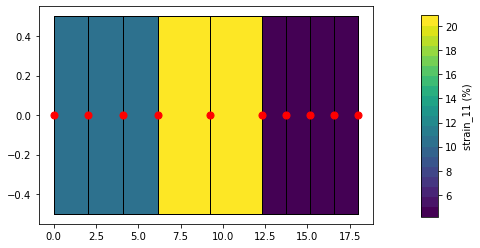

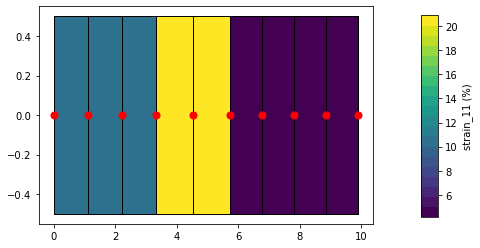

In [10]:
fem.calc_global()   # calculate global stress and strain
print('global stress: sigma_1 =', fem.glob['sig'][0].round(decimals=3), 'MPa')
print('global strain: epsilon_1 =', fem.glob['eps'][0].round(decimals=3)*100, '%')
fem.plot('strain1') # create plot
fem.plot('strain1', mag=1)


## 2-dimensional model 1: isostrain

A 2-d model with three different sections is created and subjected to a uniaxial stress parallel to the sections (y-direction). The effective eleastic properties are calculated numerically and compared to the results of the Voigt homogenization rule (isostrain assumption).

2-d Model 1: isostrain, plane stress, e2=10%
Global strain:  -0.03 0.1
Element strain Section 1:  [-0.03  0.1  -0.03  0.    0.    0.  ]
Element strain Section 2:  [-0.03  0.1  -0.03  0.    0.   -0.  ]
Element strain Section 3:  [-0.03  0.1  -0.03  0.    0.   -0.  ]
Global stress:  0.0 31111.111
Element stress (MPa) Section 1:  [    0. 20000.     0.     0.     0.     0.]
Element stress (MPa) Section 2:  [    0. 10000.     0.     0.     0.    -0.]
Element stress (MPa) Section 3:  [    0. 50000.     0.     0.     0.    -0.]
Stiffness (MPa):  311111.11111111275
Target (MPa):  311111.1111111111
Error:  -5.329070518200751e-15
----------------------------------------


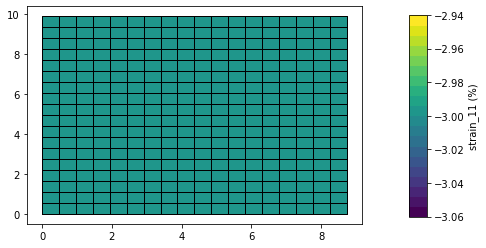

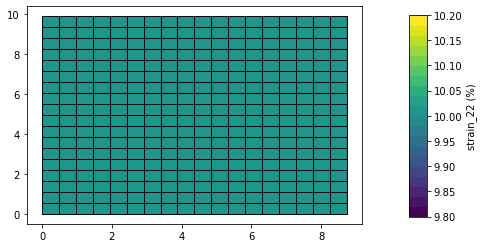

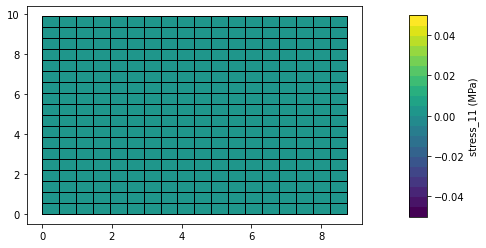

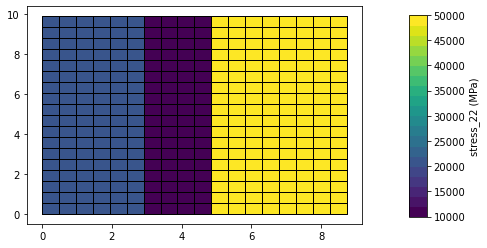

In [11]:
'2-d model, isostrain'
comp=FE.Model(dim=2, planestress=True)
comp.geom([3,2,4], LY=9)  # define sections in absolute lengths
comp.assign([mat1, mat2, mat3])
comp.bcleft(0.)
comp.bcright(0., 'force') 
comp.bcbot(0.)
comp.bctop(0.1*comp.leny, 'disp')
comp.mesh(NX=18, NY=18)
comp.solve()
comp.calc_global()
mod_stiff = comp.glob['sig'][1]/comp.glob['eps'][1]
voigt_stiff = 3.*mat1.E/9 + 2*mat2.E/9 + 4*mat3.E/9 # weighted average of Young's moduli wrt volume fractions
print('2-d Model 1: isostrain, plane stress, e2=10%')
print('Global strain: ',comp.glob['eps'][0].round(decimals=3), comp.glob['eps'][1].round(decimals=3))
print('Element strain Section 1: ', comp.element[0].eps.round(decimals=3))
print('Element strain Section 2: ', comp.element[6*18].eps.round(decimals=3))
print('Element strain Section 3: ', comp.element[10*18].eps.round(decimals=3))
print('Global stress: ',comp.glob['sig'][0].round(decimals=3), comp.glob['sig'][1].round(decimals=3))
print('Element stress (MPa) Section 1: ', comp.element[0].sig.round(decimals=3))
print('Element stress (MPa) Section 2: ', comp.element[6*18].sig.round(decimals=3))
print('Element stress (MPa) Section 3: ', comp.element[10*18].sig.round(decimals=3))
print('Stiffness (MPa): ',mod_stiff)
print('Target (MPa): ', voigt_stiff)
print('Error: ', 1.-mod_stiff/voigt_stiff)
print('----------------------------------------')

comp.plot('strain1', mag=1, shownodes=False)
comp.plot('strain2', mag=1, shownodes=False)
comp.plot('stress1', mag=1, shownodes=False)
comp.plot('stress2', mag=1, shownodes=False)


## 2-dimensional model 2: isostress

A 2-d model with three different sections is created and subjected to a uniaxial strain perpendicular to the sections (x-direction). The effective eleastic properties are calculated numerically and compared to the results of the Reuss homogenization rule (isostress assumption).

2-d Model 2: isostress, e1=10%
Global strain:  0.1 0.0
Element strain Section 1:  [ 0.105 -0.     0.     0.     0.     0.   ]
Element strain Section 2:  [ 0.209 -0.     0.     0.     0.     0.   ]
Element strain Section 3:  [ 0.042  0.     0.     0.     0.    -0.   ]
Global stress:  28175.313 12075.134
Element stress (MPa) Section 1:  [28175.313 12075.134 12075.134     0.        0.        0.   ]
Element stress (MPa) Section 2:  [28175.313 12075.134 12075.134     0.        0.        0.   ]
Element stress (MPa) Section 3:  [28175.313 12075.134 12075.134     0.        0.       -0.   ]
Stiffness (MPa):  281753.13059033663
Target (MPa):  281753.1305903399
Error:  1.1546319456101628e-14
----------------------------------------


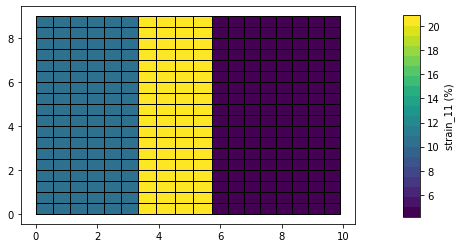

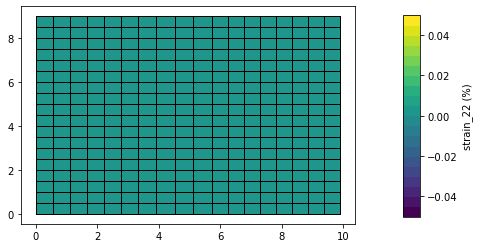

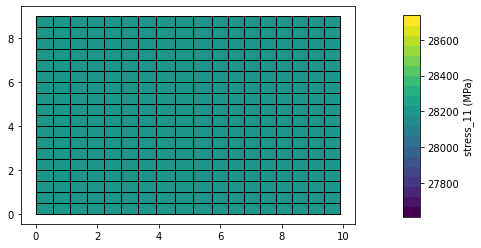

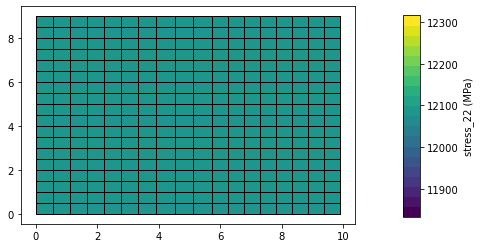

In [12]:
'2-d model, isostress'
comp2=FE.Model(dim=2, planestress=False)
comp2.geom([3,2,4], LY=9)  # define sections in absolute lengths
comp2.assign([mat1, mat2, mat3])
comp2.bcleft(0.)
comp2.bcright(0.1*comp2.lenx, 'disp') 
comp2.bcbot(0.)
comp2.bctop(0., 'disp')
comp2.mesh(NX=18, NY=18)
comp2.solve()
comp2.calc_global()
mod_stiff = comp2.glob['sig'][0]/comp2.glob['eps'][0]
reuss_stiff = 1./(3/(9*mat1.C11) + 2/(9*mat2.C11) + 4/(9*mat3.C11)) # Reuss average of stiffness
print('2-d Model 2: isostress, e1=10%')
print('Global strain: ',comp2.glob['eps'][0].round(decimals=3), comp2.glob['eps'][1].round(decimals=3))
print('Element strain Section 1: ', comp2.element[0].eps.round(decimals=3))
print('Element strain Section 2: ', comp2.element[6*18].eps.round(decimals=3))
print('Element strain Section 3: ', comp2.element[10*18].eps.round(decimals=3))
print('Global stress: ',comp2.glob['sig'][0].round(decimals=3), comp2.glob['sig'][1].round(decimals=3))
print('Element stress (MPa) Section 1: ', comp2.element[0].sig.round(decimals=3))
print('Element stress (MPa) Section 2: ', comp2.element[6*18].sig.round(decimals=3))
print('Element stress (MPa) Section 3: ', comp2.element[10*18].sig.round(decimals=3))
print('Stiffness (MPa): ',mod_stiff)
print('Target (MPa): ', reuss_stiff)
print('Error: ', 1.-mod_stiff/reuss_stiff)
print('----------------------------------------')

comp2.plot('strain1', mag=1, shownodes=False)
comp2.plot('strain2', mag=1, shownodes=False)
comp2.plot('stress1', mag=1, shownodes=False)
comp2.plot('stress2', mag=1, shownodes=False)